In [42]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
from tqdm import tqdm
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms
import pickle
import os
from PIL import Image

In [43]:
print(torch.__version__)

2.9.0+cu128


In [44]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [128]:
training_data = []
test_data = unpickle('cifar-10-batches-py/test_batch')
for i in range(1, 6):
    batch = unpickle(f'cifar-10-batches-py/data_batch_{i}')
    training_data.append(batch)

print(len(training_data))

5


In [144]:
train_images = []
train_labels = []

for batch in training_data:
    train_images.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

train_images = np.vstack(train_images)  # Stack vertically to combine all batches
train_labels = np.array(train_labels)

# Extract test data
test_images = test_data[b'data']
test_labels = np.array(test_data[b'labels'])

# Print shapes
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (50000, 3072)
Training labels shape: (50000,)
Test images shape: (10000, 3072)
Test labels shape: (10000,)


In [145]:
# 1. Raw uint8 version for visualization
raw_train_images = train_images.copy()
raw_test_images  = test_images.copy()

# 2. Reshape raw arrays
raw_train_images = raw_train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
raw_test_images  = raw_test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# 3. Normalized version for training
train_images = raw_train_images.astype('float32') / 255.0
test_images  = raw_test_images.astype('float32') / 255.0

print("Pixel range (normalized):", train_images.min(), train_images.max())


Pixel range (normalized): 0.0 1.0


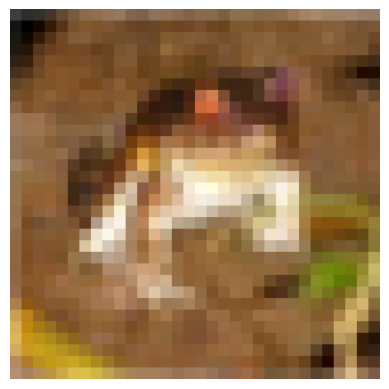

In [147]:
import cv2

img = raw_train_images[0]
bigger = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)

plt.imshow(bigger)
plt.axis('off')
plt.show()


In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16(weights='IMAGENET1K_V1')
vgg16_model = vgg16_model.to(device)


In [148]:
#Freeze all the layers and use the model only as a feature extractor on the given datase
for param in vgg16_model.parameters():
    param.requires_grad = False

In [172]:
class ImageArrayDataset(TensorDataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = (self.images[idx]*255).astype('uint8')
        img_pil = Image.fromarray((img).astype('uint8'))  # assume img in [0, 1]
        if self.transform:
            img_pil = self.transform(img_pil)
        return img_pil

In [185]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [186]:
BATCH_SIZE = 64

In [187]:
def get_dataloader(images, transform, batch_size=BATCH_SIZE):
    dataset = ImageArrayDataset(images, transform=transform)
    return DataLoader(dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=True,prefetch_factor=2,persistent_workers=True)

In [188]:
def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device, non_blocking=True)
            feats = model.features(batch)
            feats = nn.functional.adaptive_avg_pool2d(feats, (2, 2))
            feats = feats.view(feats.size(0), -1)
            features_list.append(feats.cpu().numpy())

    return np.vstack(features_list)

In [189]:
train_loader = get_dataloader(train_images, train_transform, batch_size=BATCH_SIZE)
test_loader = get_dataloader(test_images, train_transform, batch_size=BATCH_SIZE)

features_train = extract_features(vgg16_model, train_loader, device)
features_test = extract_features(vgg16_model, test_loader, device)

print(f"Extracted training features: {features_train.shape}")
print(f"Extracted test features: {features_test.shape}")

Extracted training features: (50000, 2048)
Extracted test features: (10000, 2048)


## b.

In [190]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
    def forward(self, x):
        x = self.dropout(x)  # Apply dropout
        return self.fc(x)

In [191]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [192]:
classifier = Classifier(input_size=features_train.shape[1], num_classes=10, dropout=0.5)
classifier = classifier.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(classifier.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
BATCH_SIZE = 128
EPOCHS = 30

In [194]:
X_train, X_val, y_train, y_val = train_test_split(features_train, train_labels, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = TensorDataset(torch.tensor(features_test, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [195]:
def trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience, num_epochs):
    
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1) # We get two outputs: max values and their indices
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100.0 * correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)

                _, p = out.max(1)
                val_correct += p.eq(y).sum().item()
                val_total += y.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping triggered.")
                break
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
    return train_losses, val_losses, train_accuracies, val_accuracies

In [196]:
train_losses, val_losses, train_accuracies, val_accuracies = trainer(classifier,train_loader,val_loader,criterion,optimizer,scheduler,device,5,num_epochs=EPOCHS)

Epoch 1/30: 100%|██████████| 313/313 [00:02<00:00, 134.11it/s]


Epoch 1/30 | Train Loss: 0.8166 | Val Loss: 0.5684 | Train Acc: 75.41% | Val Acc: 82.80%


Epoch 2/30: 100%|██████████| 313/313 [00:02<00:00, 129.66it/s]


Epoch 2/30 | Train Loss: 0.5908 | Val Loss: 0.5238 | Train Acc: 81.18% | Val Acc: 83.89%


Epoch 3/30: 100%|██████████| 313/313 [00:02<00:00, 131.73it/s]


Epoch 3/30 | Train Loss: 0.5663 | Val Loss: 0.5071 | Train Acc: 81.91% | Val Acc: 84.41%


Epoch 4/30: 100%|██████████| 313/313 [00:02<00:00, 130.49it/s]


Epoch 4/30 | Train Loss: 0.5648 | Val Loss: 0.5082 | Train Acc: 81.58% | Val Acc: 84.44%


Epoch 5/30: 100%|██████████| 313/313 [00:02<00:00, 130.93it/s]


Epoch 5/30 | Train Loss: 0.5635 | Val Loss: 0.5084 | Train Acc: 81.53% | Val Acc: 84.32%


Epoch 6/30: 100%|██████████| 313/313 [00:02<00:00, 132.44it/s]


Epoch 6/30 | Train Loss: 0.5613 | Val Loss: 0.5036 | Train Acc: 81.69% | Val Acc: 84.58%


Epoch 7/30: 100%|██████████| 313/313 [00:02<00:00, 124.07it/s]


Epoch 7/30 | Train Loss: 0.5612 | Val Loss: 0.5047 | Train Acc: 81.72% | Val Acc: 84.25%


Epoch 8/30: 100%|██████████| 313/313 [00:02<00:00, 121.45it/s]


Epoch 8/30 | Train Loss: 0.5636 | Val Loss: 0.5068 | Train Acc: 81.52% | Val Acc: 84.14%


Epoch 9/30: 100%|██████████| 313/313 [00:02<00:00, 131.48it/s]


Epoch 9/30 | Train Loss: 0.5612 | Val Loss: 0.5052 | Train Acc: 81.70% | Val Acc: 84.30%
Early stopping triggered.


In [217]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker ='o', linestyle='--', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', marker ='s', linestyle='--', color='orange', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

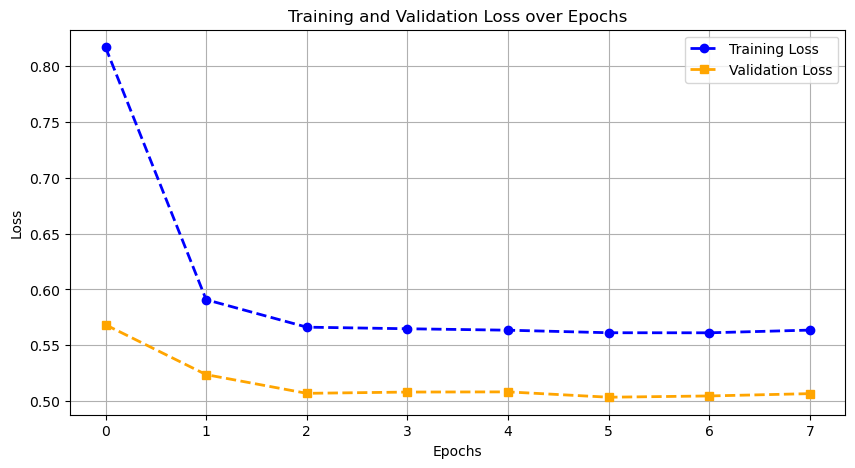

In [218]:
plot_loss(train_losses, val_losses)

In [205]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', marker ='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker ='x')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

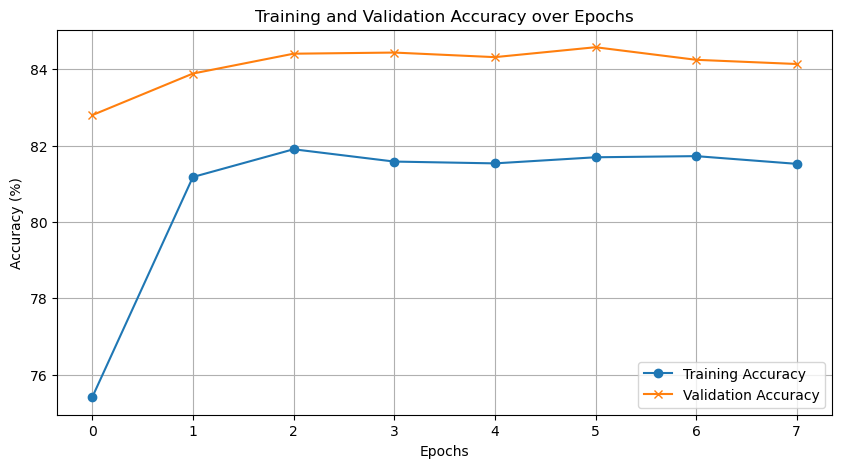

In [206]:
plot_accuracy(train_accuracies, val_accuracies)

In [201]:
def compute_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [ ]:
classifier.load_state_dict(torch.load("best_model.pth")) # Load the best model
print(f"Accuracy on test data: {compute_accuracy(classifier, test_loader, device)} %")

Accuracy on test data: 84.16 %


# Q2 Domain Shift Evaluation and Fine-Tuning:

ReadError: file could not be opened successfully:
- method gz: ReadError('not a gzip file')
- method bz2: ReadError('not a bzip2 file')
- method xz: ReadError('not an lzma file')
- method tar: ReadError('invalid header')